# Customer Churn Prediction: Version 1.0

In [1]:
# libraries to deal with data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE

# libraries for machine learning
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# libraries to save/load models
import os
import pickle
import joblib

## Loading Dataset

In [2]:
df = pd.read_csv("../data/WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter=",")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preprocessing: Exploring Data

In [3]:
# check missing data
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [4]:
# check data shape
df.shape

(7043, 21)

In [5]:
# check data summary
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [6]:
# check columns
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [7]:
# check datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Columns containing numeric values will be retained as is. Columns containing categorical (object) values will be transformed into dummy variables, encoding each unique category as an ordinal or nominal feature.

In [8]:
# gather numeric features
numeric_features = ["SeniorCitizen", "tenure", "MonthlyCharges"]

In [9]:
# drop customer ID
df = df.drop(columns=["customerID"])

In [10]:
for col in df.columns:
    if col not in numeric_features:
        print(f"\n{col}: {df[col].unique()}")


gender: ['Female' 'Male']

Partner: ['Yes' 'No']

Dependents: ['No' 'Yes']

PhoneService: ['No' 'Yes']

MultipleLines: ['No phone service' 'No' 'Yes']

InternetService: ['DSL' 'Fiber optic' 'No']

OnlineSecurity: ['No' 'Yes' 'No internet service']

OnlineBackup: ['Yes' 'No' 'No internet service']

DeviceProtection: ['No' 'Yes' 'No internet service']

TechSupport: ['No' 'Yes' 'No internet service']

StreamingTV: ['No' 'Yes' 'No internet service']

StreamingMovies: ['No' 'Yes' 'No internet service']

Contract: ['Month-to-month' 'One year' 'Two year']

PaperlessBilling: ['Yes' 'No']

PaymentMethod: ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']

TotalCharges: ['29.85' '1889.5' '108.15' ... '346.45' '306.6' '6844.5']

Churn: ['No' 'Yes']


The **`TotalCharges`** column contains numeric values stored as strings; therefore, its data type must be converted to a numeric format. During this conversion, empty strings or whitespace-only entries may result in `NaN` values.

In [11]:
# change obj datatype to numeric datatype
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [12]:
# check NaN values again
df.TotalCharges.isna().sum()

np.int64(11)

In [13]:
# check details
df[df["TotalCharges"].isna()][["tenure", "MonthlyCharges", "TotalCharges"]]

,tenure,MonthlyCharges,TotalCharges
488,0,52.55,NaN
753,0,20.25,NaN
936,0,80.85,NaN
1082,0,25.75,NaN
1340,0,56.05,NaN
3331,0,19.85,NaN
3826,0,25.35,NaN
4380,0,20.00,NaN
5218,0,19.70,NaN
6670,0,73.35,NaN


Since each customer has `MonthlyCharges` but `tenure = 0` months, these are new customers who have not been charged yet. Thus, these 11 `NaN` values should be `0.0` rather than missing.

In [14]:
# fill NaNs with 0s
df = df.fillna({"TotalCharges": 0.0})

## Data Preprocessing: Splitting Data

To prevent data leakage, the dataset must be split into training and test sets before fitting any encoders or scalers. This ensures that information from the test set does not influence the training process.

In [15]:
# separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [16]:
# all columns with obj datatype
obj_cols = [col for col in X_train.columns if X_train[col].dtype == "object"]
done_obj_cols = []

## Data Preprocessing: Encoding Categorical Variables as Numeric

In [17]:
# make a copy
label_X_train = X_train.copy()
label_X_test = X_test.copy()

The **`Contract`** column shows a clear ordinal relationship, as the categories represent increasing contract duration (Month-to-month → One year → Two year). Therefore, it is encoded using ordinal encoding.

In [18]:
# ordinal encoding
ordinal_encoder = OrdinalEncoder()
label_X_train['Contract'] = ordinal_encoder.fit_transform(X_train[['Contract']])
label_X_test['Contract'] = ordinal_encoder.transform(X_test[['Contract']])

# update encoded obj columns
done_obj_cols.append('Contract')

The following columns:
- **`gender`**
- **`Partner`**
- **`Dependents`**
- **`PhoneService`**
- **`PaperlessBilling`**

are binary categorical variables with two possible values and no inherent ordering. These columns are encoded using binary encoding (0/1), which is both efficient and appropriate for modeling.

In [19]:
# get columns
binary_encoded_cols = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling'] 

# binary encoding
for col in binary_encoded_cols:
    if col == 'gender':
        label_X_train[col] = X_train[col].map({'Male': 1, 'Female': 0})
        label_X_test[col] = X_test[col].map({'Male': 1, 'Female': 0})
    else:
        label_X_train[col] = X_train[col].map({"Yes": 1, "No": 0})
        label_X_test[col] = X_test[col].map({"Yes": 1, "No": 0})

# update encoded obj columns
done_obj_cols = done_obj_cols + binary_encoded_cols

In [20]:
# rename the 'gender' column for better interpretability
label_X_train = label_X_train.rename(columns={'gender': 'is_male'})
label_X_test = label_X_test.rename(columns={'gender': 'is_male'})

The following columns:
- **`MultipleLines`**
- **`InternetService`**
- **`OnlineSecurity`**
- **`OnlineBackup`**
- **`DeviceProtection`**
- **`TechSupport`**
- **`StreamingTV`**
- **`StreamingMovies`**
- **`PaymentMethod`**

contain multiple categorical values with no natural order. Encoding them as ordinal values would introduce artificial relationships between categories, so they are encoded using one-hot (dummy) encoding.

However, one-hot encoding is only suitable for categorical variables with low to moderate cardinality (typically 2-10 unique categories). Columns with high cardinality (many unique values, typically >15-20) should not be one-hot encoded due to several issues:

1. **Curse of Dimensionality**: High-cardinality variables create a large number of binary features (one per category), dramatically increasing the feature space.
2. **Sparse Data**: One-hot encoding produces sparse matrices (mostly zeros) for high-cardinality variables.
3. **Information Loss**: For high-cardinality variables, one-hot encoding treats each category as completely independent, which may not capture meaningful relationships between categories.

In [21]:
# get columns
one_hot_encoded_cols = list(set(obj_cols) - set(done_obj_cols))

# check cardinality (number of unique values in each column)
one_hot_encoded_cols_nunique = list(map(lambda col: X_train[col].nunique(), one_hot_encoded_cols))
d = dict(zip(one_hot_encoded_cols, one_hot_encoded_cols_nunique))
sorted(d.items(), key=lambda x: x[1])

[('StreamingTV', 3),
 ('MultipleLines', 3),
 ('OnlineBackup', 3),
 ('DeviceProtection', 3),
 ('InternetService', 3),
 ('TechSupport', 3),
 ('OnlineSecurity', 3),
 ('StreamingMovies', 3),
 ('PaymentMethod', 4)]

For the columns selected for one-hot encoding in this dataset, the cardinality check confirms that all columns have low cardinality (2-4 unique values), making them suitable for one-hot encoding.

In [22]:
# one-hot encoding
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_encoded = OH_encoder.fit_transform(label_X_train[one_hot_encoded_cols])
X_test_encoded = OH_encoder.transform(label_X_test[one_hot_encoded_cols])

# update encoded obj columns
done_obj_cols = done_obj_cols + one_hot_encoded_cols

One-hot encoding creates multiple columns from each categorical column, unlike binary/ordinal encoding which replace values in-place. This column expansion requires converting the NumPy array to a DataFrame, preserving indices, dropping original columns, and concatenating the new columns with existing features.

In [23]:
# get feature names
OH_feature_names = OH_encoder.get_feature_names_out(one_hot_encoded_cols)

# convert to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=OH_feature_names, index=label_X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=OH_feature_names, index=label_X_test.index)

# drop original columns
label_X_train = label_X_train.drop(columns=one_hot_encoded_cols)
label_X_test = label_X_test.drop(columns=one_hot_encoded_cols)

# concatenate encoded columns
label_X_train = pd.concat([label_X_train, X_train_encoded_df], axis=1)
label_X_test = pd.concat([label_X_test, X_test_encoded_df], axis=1)

The **`Churn`** column is the target variable with two categories (Yes and No); therefore, it is encoded using `LabelEncoder` to convert the labels into a numerical format suitable for modeling.

In [24]:
# label encoding
label_encoder = LabelEncoder()
label_y_train = label_encoder.fit_transform(y_train)
label_y_test = label_encoder.transform(y_test)

# recovert to original dtype
label_y_train = pd.Series(label_y_train)
label_y_test = pd.Series(label_y_test)

## Data Preprocessing: SMOTE (Synthetic Minority Oversampling Technique)

SMOTE is suitable for classification with imbalanced classes and sufficient minority samples, **applied only to the training set after splitting to avoid data leakage**. It should be avoided for balanced classes, very small datasets, or when the minority class has fewer than 10–20 samples. Applying SMOTE to the test set alters its distribution, violates independence, and produces biased performance metrics. SMOTE requires numeric features, so **encoding should be performed before balancing**.

In [25]:
# check class balance
label_y_train.value_counts()

0    4138
1    1496
Name: count, dtype: int64

In [26]:
# apply SMOTE ONLY to training data
smote = SMOTE(random_state=42)
label_X_train_smote, label_y_train_smote = smote.fit_resample(label_X_train, label_y_train)

In [27]:
# recheck class balance
label_y_train_smote.value_counts()

0    4138
1    4138
Name: count, dtype: int64

## Model: Selection Rationale

Three models are selected for customer churn prediction:

1. **Decision Tree**: A baseline model offering interpretability and the ability to capture non-linear relationships, useful for identifying key churn indicators.

2. **Random Forest**: An ensemble method that reduces overfitting through multiple trees. It handles feature interactions well and provides feature importance, making it suitable for identifying churn drivers.

3. **XGBoost**: A gradient boosting algorithm effective for imbalanced datasets (common in churn prediction) and complex feature interactions. It typically delivers high predictive performance.

These models represent different approaches (single tree, bagging, and boosting), enabling comprehensive comparison for robust churn prediction.

In [28]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "XGBoost ": XGBClassifier(random_state=42)
}

## Model: Cross-Validation

Cross-validation provides a robust performance estimate by splitting training data into multiple folds, using each fold for both training and validation. This gives a more reliable estimate than a single train-test split.

Cross-validation should be performed **before fitting the model** to:
1. **Compare Models**: Evaluate multiple models to select the best performer without using the test set
2. **Prevent Overfitting**: Avoid fitting on the full training data first, which can cause overfitting
3. **Model Selection**: Choose the best model based on CV scores, then fit only the selected model
4. **Preserve Test Set**: Keep the test set untouched until final evaluation for unbiased generalization estimate

### (i) Regular K-Fold Cross-Validation

**Regular K-Fold** randomly splits data into k folds, which can result in inconsistent class distributions across folds. 

In [29]:
# dictionary to store the cross validation results
cv_scores = {}

# perform regular 5-fold cross validation for each model
for model_name, model in models.items():
    cv_scores[model_name] = cross_val_score(model, label_X_train_smote, label_y_train_smote, cv=5, scoring="accuracy")

print("average accuracy:") 
for model_name, scores in cv_scores.items():
    avg_score = sum(scores) / len(scores)
    print(f"\t{model_name}\t{avg_score:.4f}")

average accuracy:
	Decision Tree	0.8037
	Random Forest	0.8379
	XGBoost 	0.8342


### (ii) Stratified K-Fold Cross-Validation

**Stratified K-Fold** ensures each fold maintains the same class distribution as the original dataset, providing more reliable performance estimates, especially for imbalanced data.

In [30]:
# initialize stratified K-Fold (preserves class distribution)
stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# dictionary to store cross validation results
SKF_cv_scores = {}

# perform stratified 5-fold cross validation for each model
for model_name, model in models.items():
    SKF_cv_scores[model_name] = cross_val_score(model, label_X_train_smote, label_y_train_smote, cv=stratified_kfold, scoring="accuracy")

print("average accuracy:") 
for model_name, scores in SKF_cv_scores.items():
    avg_score = sum(scores) / len(scores)
    print(f"\t{model_name}\t{avg_score:.4f}")

average accuracy:
	Decision Tree	0.8096
	Random Forest	0.8516
	XGBoost 	0.8473


With default parameters, the **`Random Forest`** model achieves the highest accuracy compared to the other models in both regular K-Fold and Stratified K-Fold cross-validation. It is followed closely by **`XGBoost`** and further by **`Decision Tree`**.

## Model: Training & Evaluation

In [31]:
# get class names for confusion matrix
## actual labels
class_names = []

## get unique classes (integers)
classes =  sorted(label_y_test.unique())

## map integers to actual labels
for c in classes:
    if c == 0:
        class_names.append("Staying")
    elif c == 1:
        class_names.append("Leaving")

### Random Forest

In [32]:
# model training
rfc = RandomForestClassifier(random_state=42)
rfc.fit(label_X_train_smote, label_y_train_smote)

,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",100
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric

accuracy: 0.7835344215755855

classification report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1036
           1       0.61      0.50      0.55       373

    accuracy                           0.78      1409
   macro avg       0.72      0.69      0.70      1409
weighted avg       0.77      0.78      0.78      1409



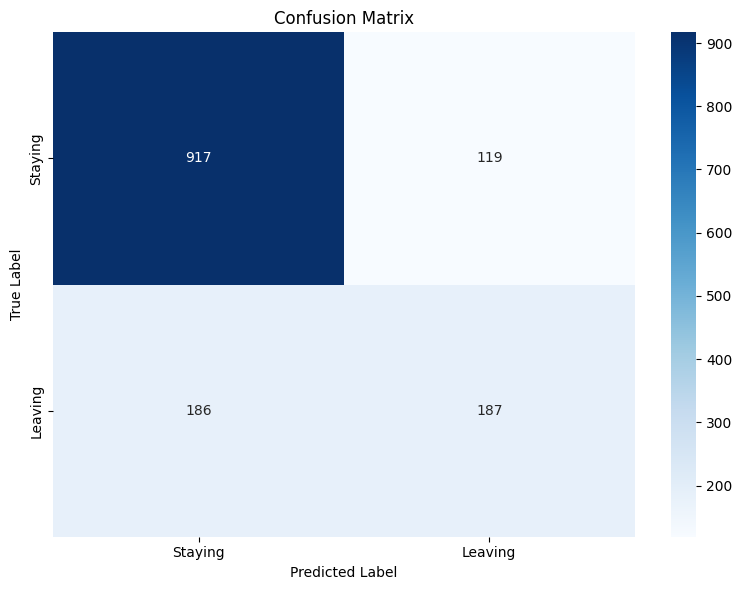

In [33]:
# evaluate on test data
label_y_test_pred = rfc.predict(label_X_test)

cm = confusion_matrix(label_y_test, label_y_test_pred)
print(f"accuracy: {accuracy_score(label_y_test, label_y_test_pred)}")
print("\nclassification report:\n", classification_report(label_y_test, label_y_test_pred))

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Extreme Gradient Boosting (XGBoost)

In [34]:
# model training
xgb = XGBClassifier(random_state=42)
xgb.fit(label_X_train_smote, label_y_train_smote)

,"objective objective: typing.Union[str, xgboost.sklearn._SklObjWProto, typing.Callable[[typing.Any, typing.Any], typing.Tuple[numpy.ndarray, numpy.ndarray]], NoneType]Specify the learning task and the corresponding learning objective or a customobjective function to be used.For custom objective, see :doc:`/tutorials/custom_metric_obj` and:ref:`custom-obj-metric` for more information, along with the end note forfunction signatures.",'binary:logistic'
,"base_score base_score: typing.Union[float, typing.List[float], NoneType]The initial prediction score of all instances, global bias.",None
,booster,None
,"callbacks callbacks: typing.Optional[typing.List[xgboost.callback.TrainingCallback]]List of callback functions that are applied at end of each iteration.It is possible to use predefined callbacks by using:ref:`Callback API `... note:: States in callback are not preserved during training, which means callback objects can not be reused for multiple training sessions without reinitialization or deepcopy... code-block:: python for params in parameters_grid: # be sure to (re)initialize the callbacks before each run callbacks = [xgb.callback.LearningRateScheduler(custom_rates)] reg = xgboost.XGBRegressor(**params, callbacks=callbacks) reg.fit(X, y)",None
,colsample_bylevel colsample_bylevel: typing.Optional[float]Subsample ratio of columns for each level.,None
,colsample_bynode colsample_bynode: typing.Optional[float]Subsample ratio of columns for each split.,None
,colsample_bytree colsample_bytree: typing.Optional[float]Subsample ratio of columns when constructing each tree.,None
,"device device: typing.Optional[str].. versionadded:: 2.0.0Device ordinal, available options are `cpu`, `cuda`, and `gpu`.",None
,"early_stopping_rounds early_stopping_rounds: typing.Optional[int].. versionadded:: 1.6.0- Activates early stopping. Validation metric needs to improve at least once in every **early_stopping_rounds** round(s) to continue training. Requires at least one item in **eval_set** in :py:meth:`fit`.- If early stopping occurs, the model will have two additional attributes: :py:attr:`best_score` and :py:attr:`best_iteration`. These are used by the :py:meth:`predict` and :py:meth:`apply` methods to determine the optimal number of trees during inference. If users want to access the full model (including trees built after early stopping), they can specify the `iteration_range` in these inference methods. In addition, other utilities like model plotting can also use the entire model.- If you prefer to discard the trees after `best_iteration`, consider using the callback function :py:class:`xgboost.callback.EarlyStopping`.- If there's more than one item in **eval_set**, the last entry will be used for early stopping. If there's more than one metric in **eval_metric**, the last metric will be used for early stopping.",None
,enable_categorical enable_categorical: boolSee the same parameter of :py:class:`DMatrix` for details.,False
,"eval_metric eval_metric: typing.Union[str, typing.List[typing.Union[str, typing.Callable]], typing.Callable, NoneType].. versionadded:: 1.6.0Metric used for monitoring the training result and early stopping. It can be astring or list of strings as names of predefined metric in XGBoost (See:doc:`/parameter`), one of the metrics in :py:mod:`sklearn.metrics`, or anyother user defined metric that looks like `sklearn.metrics`.If custom objective is also provided, then custom metric should implement thecorresponding reverse link function.Unlike the `scoring` parameter commonly used in scikit-learn, when a callableobject is provided, it's assumed to be a cost function and by default XGBoostwill minimize the result during early stopping.For advanced usage on Early stopping like directly choosing to maximize insteadof minimize, see :py:obj:`xgboost.callback.EarlyStopping`.See :doc:`/tutorials/custom_metric_obj` and :ref:`custom-obj-metric` for moreinformation... code-block:: python from sklearn.datasets import load_diabetes 

accuracy: 0.7920511000709723

classification report:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      1036
           1       0.62      0.55      0.58       373

    accuracy                           0.79      1409
   macro avg       0.73      0.72      0.72      1409
weighted avg       0.79      0.79      0.79      1409



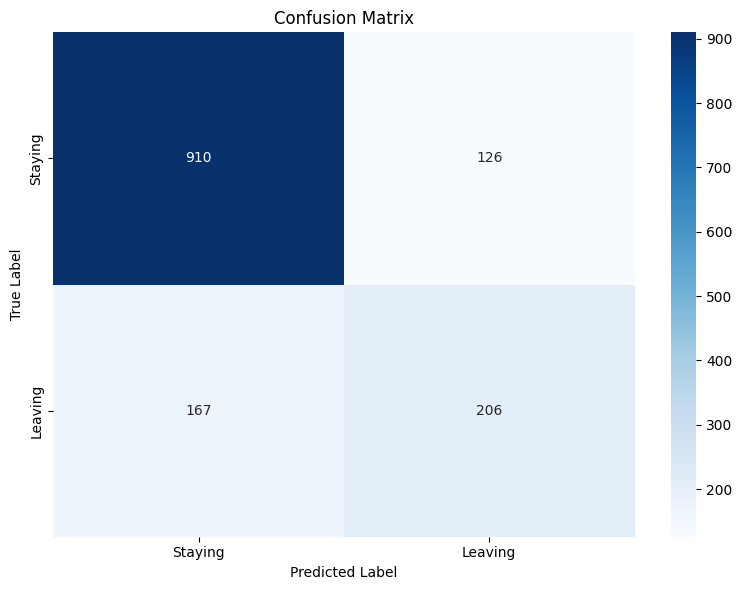

In [35]:
# evaluate on test data
label_y_test_pred = xgb.predict(label_X_test)

cm = confusion_matrix(label_y_test, label_y_test_pred)
print(f"accuracy: {accuracy_score(label_y_test, label_y_test_pred)}")
print("\nclassification report:\n", classification_report(label_y_test, label_y_test_pred))

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

### Decision Tree

In [36]:
# model training
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(label_X_train_smote, label_y_train_smote)

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",None
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

accuracy: 0.7288857345635202

classification report:
               precision    recall  f1-score   support

           0       0.83      0.80      0.81      1036
           1       0.49      0.54      0.52       373

    accuracy                           0.73      1409
   macro avg       0.66      0.67      0.66      1409
weighted avg       0.74      0.73      0.73      1409



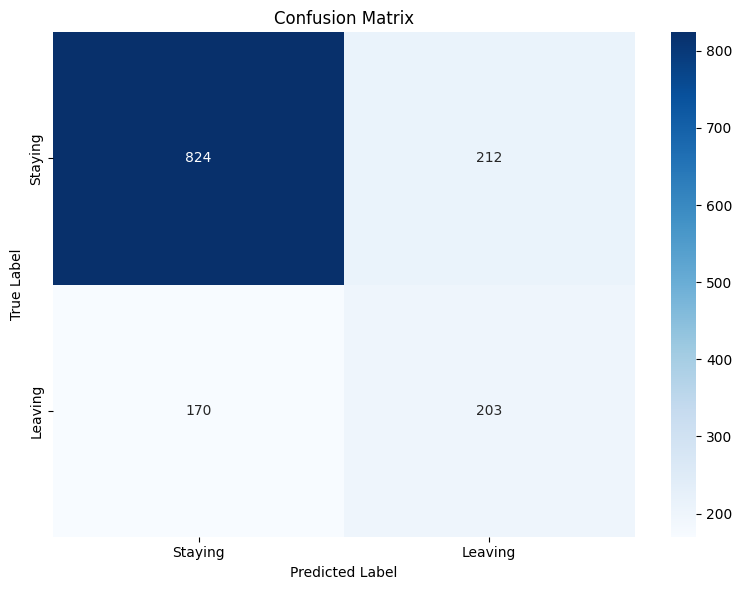

In [37]:
# evaluate on test data
label_y_test_pred = dtc.predict(label_X_test)

cm = confusion_matrix(label_y_test, label_y_test_pred)
print(f"accuracy: {accuracy_score(label_y_test, label_y_test_pred)}")
print("\nclassification report:\n", classification_report(label_y_test, label_y_test_pred))

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

Although the **`Random Forest`** model achieves the highest accuracy in cross-validation, the **`XGBoost`** model performs better on the test set. Therefore, **`XGBoost`** is chosen for hyperparameter tuning.

## Model: Hyperparameter Tuning for XGBoost

Hyperparameter tuning is performed in two steps to optimize both efficiency and model performance.

1. The first step uses `GridSearchCV` to systematically find the best combination of `n_estimators` and `learning_rate`, which are critical parameters that significantly influence model performance and have strong interaction effects.

2. The second step uses `RandomizedSearchCV` to explore the remaining hyperparameters (regularization, tree structure, and sampling parameters) while using the optimal `n_estimators` and `learning_rate` from the first step.

This approach ensures thorough optimization of the most important parameters while efficiently exploring the broader hyperparameter space, resulting in a well-tuned model without the computational cost of a full grid search across all parameters.

### (i) GridSearchCV

In [38]:
# create a new unfitted model
xgb_model_step1 = XGBClassifier(random_state=42, eval_metric='logloss')

In [39]:
# define parameter distributions
param_grid_step1 = {
    'n_estimators': [100, 200, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2]
}

# create GridSearchCV object
grid_search_step1 = GridSearchCV(
    estimator=xgb_model_step1,
    param_grid=param_grid_step1,
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [40]:
# start grid search
grid_search_step1.fit(label_X_train_smote, label_y_train_smote)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'learning_rate': [0.01, 0.05, ...], 'n_estimators': [100, 200, ...]}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and parameter candidate is dis

In [41]:
# get best parameters and score
best_n_estimators = grid_search_step1.best_params_['n_estimators']
best_learning_rate = grid_search_step1.best_params_['learning_rate']
print(f"\nBest parameters: {grid_search_step1.best_params_}")
print(f"\nBest CV score (Step 1): {grid_search_step1.best_score_:.4f}")

# create a new unfitted model using the best hyparameters
xgb_model_step2 = XGBClassifier(
    n_estimators=best_n_estimators,
    learning_rate=best_learning_rate,
    random_state=42,
    eval_metric='logloss'
)


Best parameters: {'learning_rate': 0.05, 'n_estimators': 200}

Best CV score (Step 1): 0.8540


### (ii) RandomizedSearchCV

In [42]:
# define parameter distributions
param_distributions_step2 = {
    'max_depth': [3, 5, 7, 9],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.2, 0.3],
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3]      # L2 regularization
}

# create RandomizedSearchCV object
random_search_step2 = RandomizedSearchCV(
    estimator=xgb_model_step2,
    param_distributions=param_distributions_step2,
    n_iter=50,  # number of parameter settings to sample
    cv=stratified_kfold,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42
)

In [43]:
# start the random search
random_search_step2.fit(label_X_train_smote, label_y_train_smote)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.","XGBClassifier...ree=None, ...)"
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'colsample_bytree': [0.8, 0.9, ...], 'gamma': [0, 0.1, ...], 'max_depth': [3, 5, ...], 'min_child_weight': [1, 3, ...], ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",50
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'accuracy'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... 

In [44]:
# get best parameters and score
print(f"\nBest parameters: {random_search_step2.best_params_}")
print(f"\nBest CV score (Step 2): {random_search_step2.best_score_:.4f}")

# get the best model
best_xgb_model = random_search_step2.best_estimator_


Best parameters: {'subsample': 0.9, 'reg_lambda': 1, 'reg_alpha': 0, 'min_child_weight': 3, 'max_depth': 5, 'gamma': 0.1, 'colsample_bytree': 0.8}

Best CV score (Step 2): 0.8552


In [45]:
# combine all best parameters
final_best_params = {
    'n_estimators': best_n_estimators,
    'learning_rate': best_learning_rate,
    **random_search_step2.best_params_
}

accuracy: 0.8062455642299503

classification report:
               precision    recall  f1-score   support

           0       0.86      0.87      0.87      1036
           1       0.64      0.62      0.63       373

    accuracy                           0.81      1409
   macro avg       0.75      0.75      0.75      1409
weighted avg       0.80      0.81      0.81      1409



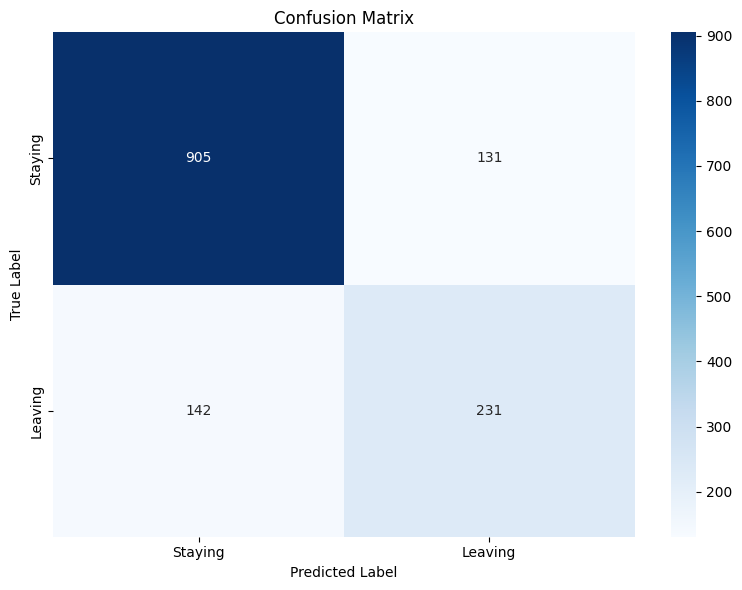

In [46]:
# evaluate best model on test set
label_y_test_pred = best_xgb_model.predict(label_X_test)

cm = confusion_matrix(label_y_test, label_y_test_pred)
print(f"accuracy: {accuracy_score(label_y_test, label_y_test_pred)}")
print("\nclassification report:\n", classification_report(label_y_test, label_y_test_pred))

# create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

## Saving Models, Preprocessed Datasets, & Preprocessing Objects

Saving trained models enables quick predictions without retraining. Preprocessed datasets allow rapid experimentation without rerunning preprocessing. Preprocessing objects (encoders, scalers) ensure new data is transformed identically to training data, preventing data leakage and maintaining model consistency in production.

In [47]:
# create directory if it doesn't exist
os.makedirs('../models', exist_ok=True)

# save the tuned XGBoost (best performing model)
joblib.dump(best_xgb_model, '../models/churn_predictor_xgboost.joblib')

# (optional) save Random Forest as backup (close performance)
joblib.dump(rfc, '../models/churn_predictor_random_forest.joblib')

['../models/churn_predictor_random_forest.joblib']

In [48]:
# create directory if it doesn't exist
os.makedirs('../data/processed', exist_ok=True)

# save processed training and test datasets (with SMOTE)
joblib.dump(label_X_train_smote, '../data/processed/X_train_smote.joblib')
joblib.dump(label_y_train_smote, '../data/processed/y_train_smote.joblib')

# save processed training and test datasets (without SMOTE; original)
joblib.dump(label_X_train, '../data/processed/X_train.joblib')
joblib.dump(label_y_train, '../data/processed/y_train.joblib')

# save test datasets (same for both versions)
joblib.dump(label_X_test, '../data/processed/X_test.joblib')
joblib.dump(label_y_test, '../data/processed/y_test.joblib')

# (optional) save feature names for reference - to check if new data has all required features
joblib.dump(label_X_train_smote.columns.tolist(), '../data/processed/feature_names.joblib')

['../data/processed/feature_names.joblib']

In [49]:
# create directory if it doesn't exist
os.makedirs('../preprocessors', exist_ok=True)

# save preprocessing objects
joblib.dump(ordinal_encoder, '../models/ordinal_encoder.joblib')
joblib.dump(OH_encoder, '../models/onehot_encoder.joblib')
joblib.dump(label_encoder, '../models/label_encoder.joblib')
joblib.dump(smote, '../models/smote.joblib')

['../models/smote.joblib']

This notebook is done by `La Wun Nannda`.